# Quantified Sleep: Model interpretation

In [1]:
from pathlib import Path

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from grid_search import markov_stacking

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
DATADIR = Path('../Data/')
FIGSDIR = Path('../Figs/')

In [4]:
# Read in the best dataset
df = pd.read_csv(DATADIR/'Trainable/pre_markov_matrixfactorization.csv')
print(df.shape)

df = markov_stacking(df).dropna()
print(df.shape)

X, y = df.copy(), df['target']
X.drop('target', axis=1, inplace=True)
colnames = X.columns
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
print(X.shape, y.shape)

(482, 193)
(475, 1530)
(475, 1529) (475,)


## Recursive feature elimination

In [5]:
selector = RFECV(Lasso(), step=1, cv=5, verbose=0)
selector = selector.fit(X, y)

In [6]:
selector.n_features_

36

In [7]:
df_feats = pd.DataFrame.from_dict({'feature': colnames, 'ranking': selector.ranking_})
ranked_feats = list(df_feats.sort_values(by='ranking').index.values)
df_feats.sort_values(by='ranking').head(20)

,feature,ranking
528,hk_act_4h_-1day,1
514,hk_act_2h_-1day,1
78,nomie_caf_net_hour_min,1
80,nomie_caf_net_hour_range,1
81,nomie_caf_net_hour_spread,1
553,hk_act_7h_-5day,1
1337,aw_weather_rain_median_-5day,1
1321,aw_weather_pressure_median_-3day,1
1393,aw_weather_wind_speed_median_-5day,1
620,hk_act_17h_-2day,1


In [8]:
print(df_feats[df_feats.ranking == 1].feature.values)

['sleep_yesterday_midpoint_time' 'sleep_yesterday_rmssd'
 'sleep_yesterday_score' 'sleep_yesterday_score_alignment'
 'sleep_yesterday_score_deep' 'sleep_yesterday_score_disturbances'
 'sleep_yesterday_score_efficiency' 'sleep_yesterday_score_latency'
 'travelling' 'hk_act_9h' 'nomie_caf_net_hour_min'
 'nomie_caf_net_hour_range' 'nomie_caf_net_hour_spread'
 'melatonin_quantity' 'aw_geohash8_num_unique' 'hk_act_2h_-1day'
 'hk_act_4h_-1day' 'hk_act_7h_-5day' 'hk_act_17h_-2day'
 'hk_act_night_mean_-1day' 'nomie_caf_value_sum_-4day'
 'cbd_hour_delta_-3day' 'zero_hours_-1day' 'zero_night_eating_-1day'
 'wol_intensive_workout_-2day' 'wol_read_book_-4day'
 'aw_activ_stationary_-7day' 'aw_loc_geohash_u173w_mean_-7day'
 'aw_weather_pressure_median_-3day' 'aw_weather_rain_median_-5day'
 'aw_weather_wind_speed_median_-5day' 'aw_weather_wind_speed_std_-3day'
 'aw_hr_heart_rate_median_night_-1day' 'aw_hr_heart_rate_std_day_-1day'
 'aw_hr_heart_rate_std_morn_-7day' 'aw_hr_heart_rate_std_night_-1day']

In [9]:
df_feats['prefix'] = df_feats['feature'].apply(lambda c: c.split('_')[0])
df_feats['suffix'] = df_feats['feature'].apply(lambda c: c.split('_')[-1])

In [10]:
df_feats.groupby('prefix').mean().sort_values('ranking')

,ranking
prefix,
zero,160.575000
wol,165.171875
mood,279.666667
sleep,592.365385
aw,598.760000
is,776.333333
daily,789.750000
travelling,800.750000
at,818.125000


## Fit the model

In [12]:
model = LassoCV(cv=5).fit(X, y)
r2_score = model.score(X, y)
print('R2 score:', r2_score)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.015749598950379, tolerance: 3.242195789473684
  positive)


R2 score: 0.5463263394070105


In [13]:
# https://christophm.github.io/interpretable-ml-book/limo.html#interpretation
r2_adj = 1 - (1 - r2_score) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))
print('Adjusted R2 score:', r2_adj)

Adjusted R2 score: 1.2038306304465185


In [14]:
model.alpha_

0.5675203412644593

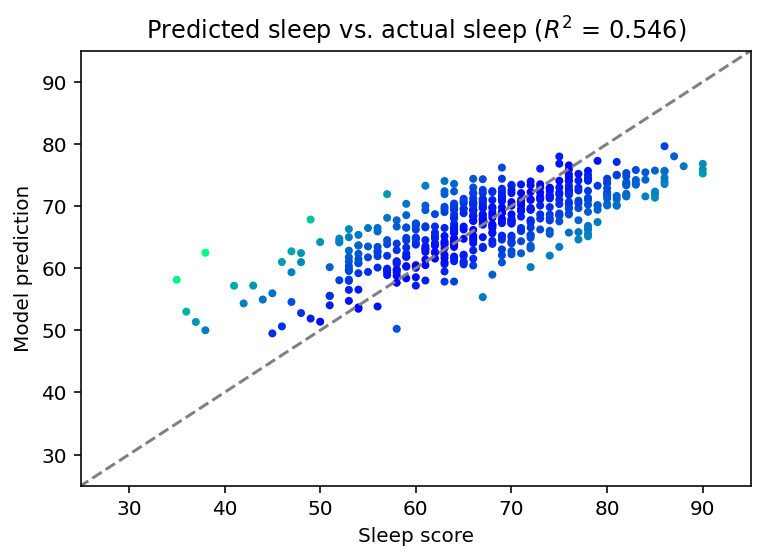

In [15]:
true, pred = y.values, model.predict(X)
residuals = np.sqrt((true - pred)**2)
plt.scatter(y, model.predict(X), marker='.', c=residuals, cmap='winter')
plt.plot([0, 100], [0, 100], label='Ideal', linestyle='--', color='grey')
plt.ylim(25,95); plt.xlim(25,95)
plt.xlabel('Sleep score'); plt.ylabel('Model prediction')
plt.title(r"Predicted sleep vs. actual sleep ($R^2$ = " + f'{r2_score :.3f})')
plt.savefig(FIGSDIR/f"interp_calibration.eps")
plt.show()

## CV refitting of model to quantify variance of coefficients

In [16]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

from sklearn.model_selection import RepeatedKFold, cross_validate

cv_model = cross_validate(
    Lasso(alpha=0.567), X, y, cv=RepeatedKFold(n_splits=5, n_repeats=20),
    return_estimator=True, n_jobs=-1)

In [17]:
coefs = pd.DataFrame(
    [est.coef_ *
     X.std(axis=0)
     for est in cv_model['estimator']],
    columns=colnames)

In [18]:
# Select only the coefficients that weren't ALWAYS zero for further inspection
nb_coefs = [c for c in coefs.columns if not np.all(np.abs(coefs[c]) < 0.5)]
_coefs = coefs[nb_coefs]
_coefs.shape

(100, 69)

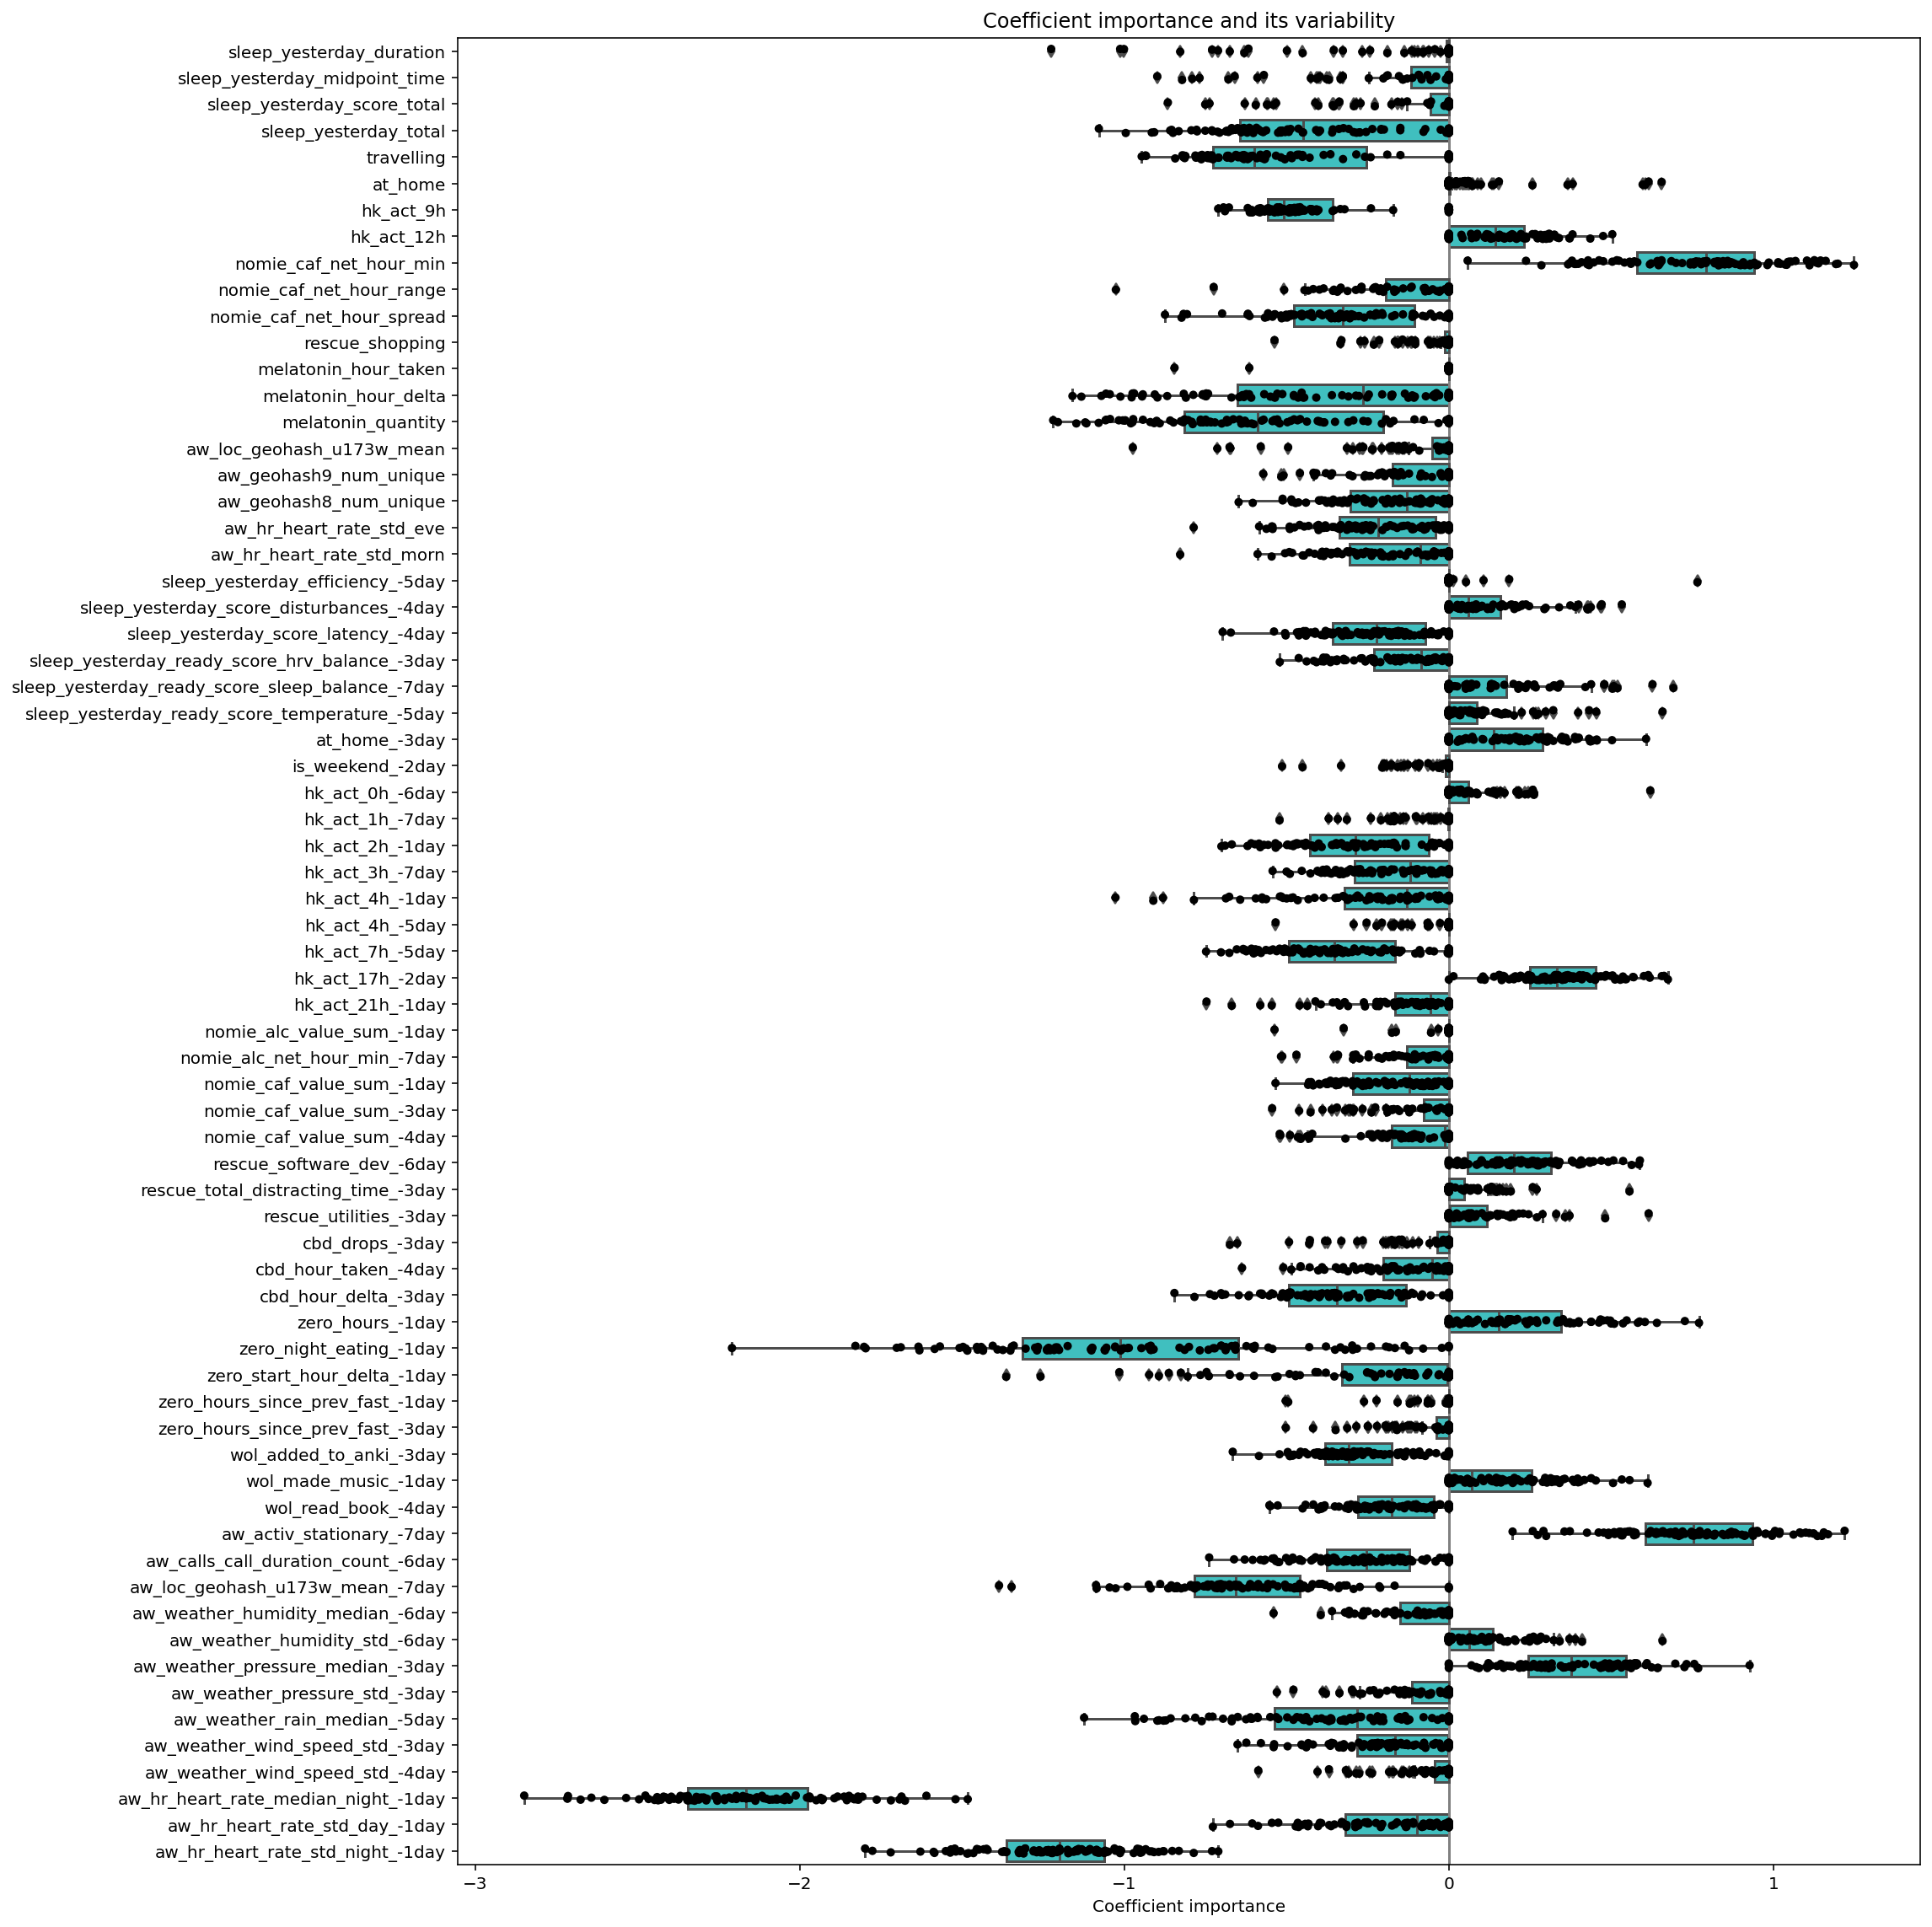

In [19]:
plt.figure(figsize=(16,16))
plt.axvline(x=0, color='.5')
sns.boxplot(data=_coefs, orient='h', color='cyan', saturation=0.5)
sns.stripplot(data=_coefs, orient='h', color='k')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
# plt.subplots_adjust(left=.3)
plt.tight_layout()
plt.savefig(FIGSDIR/f'interp_coeff_importance_boxes.eps')
plt.show()

In [20]:
df_coefs = _coefs.agg(['mean', 'std']).T.reset_index()
df_coefs.rename({'index': 'feature'}, axis=1, inplace=True)
df_coefs['abs_mean'] = np.abs(df_coefs['mean'])
df_coefs.sort_values('abs_mean', ascending=False, inplace=True)
df_coefs.head(30)

,feature,mean,std,abs_mean
66,aw_hr_heart_rate_median_night_-1day,-2.165990,0.274765,2.165990
68,aw_hr_heart_rate_std_night_-1day,-1.208752,0.228306,1.208752
49,zero_night_eating_-1day,-0.959483,0.492088,0.959483
8,nomie_caf_net_hour_min,0.768295,0.249888,0.768295
56,aw_activ_stationary_-7day,0.754725,0.229445,0.754725
58,aw_loc_geohash_u173w_mean_-7day,-0.628609,0.249681,0.628609
14,melatonin_quantity,-0.540447,0.368078,0.540447
4,travelling,-0.488146,0.299567,0.488146
6,hk_act_9h,-0.410817,0.222324,0.410817
3,sleep_yesterday_total,-0.393141,0.309898,0.393141


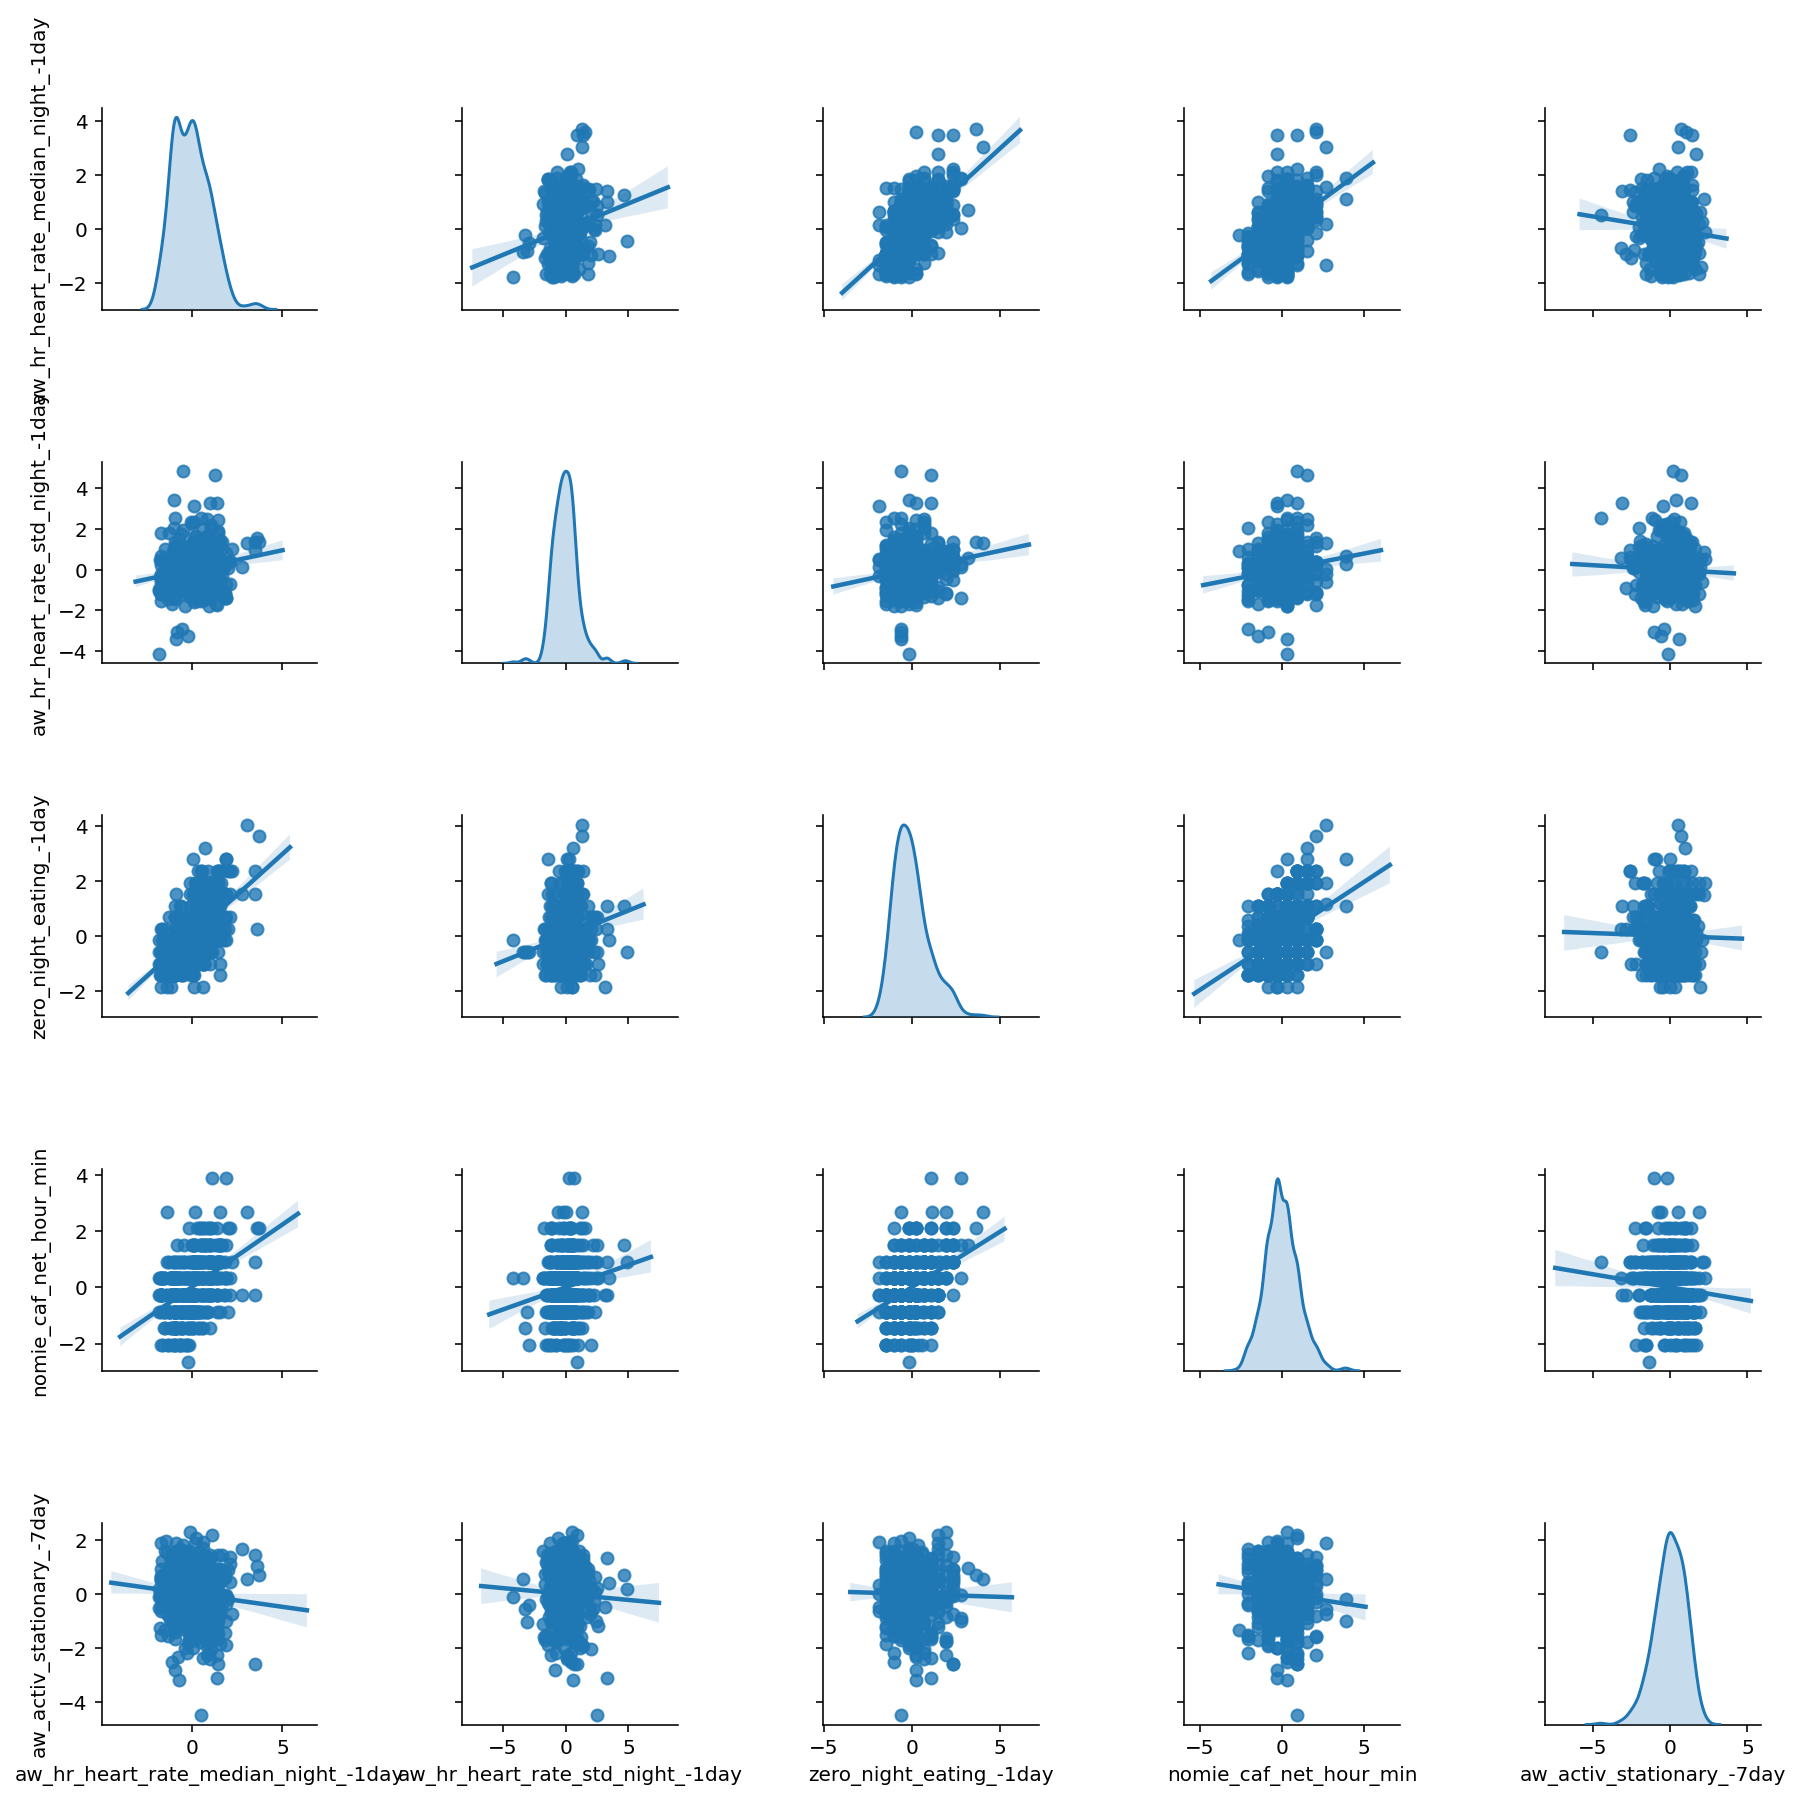

In [21]:
sns.pairplot(X[df_coefs.head(5).feature], kind='reg', diag_kind='kde')
plt.savefig(FIGSDIR/'interp_pairplot_top_features.png', dpi=500)
# plt.tight_layout()
plt.show()

## SHAP interpretation

In [ ]:
import shap

In [23]:
explainer = shap.KernelExplainer(model.predict, shap.kmeans(X, 30))

In [ ]:
sample = X.copy()
shap_values = explainer.shap_values(sample)

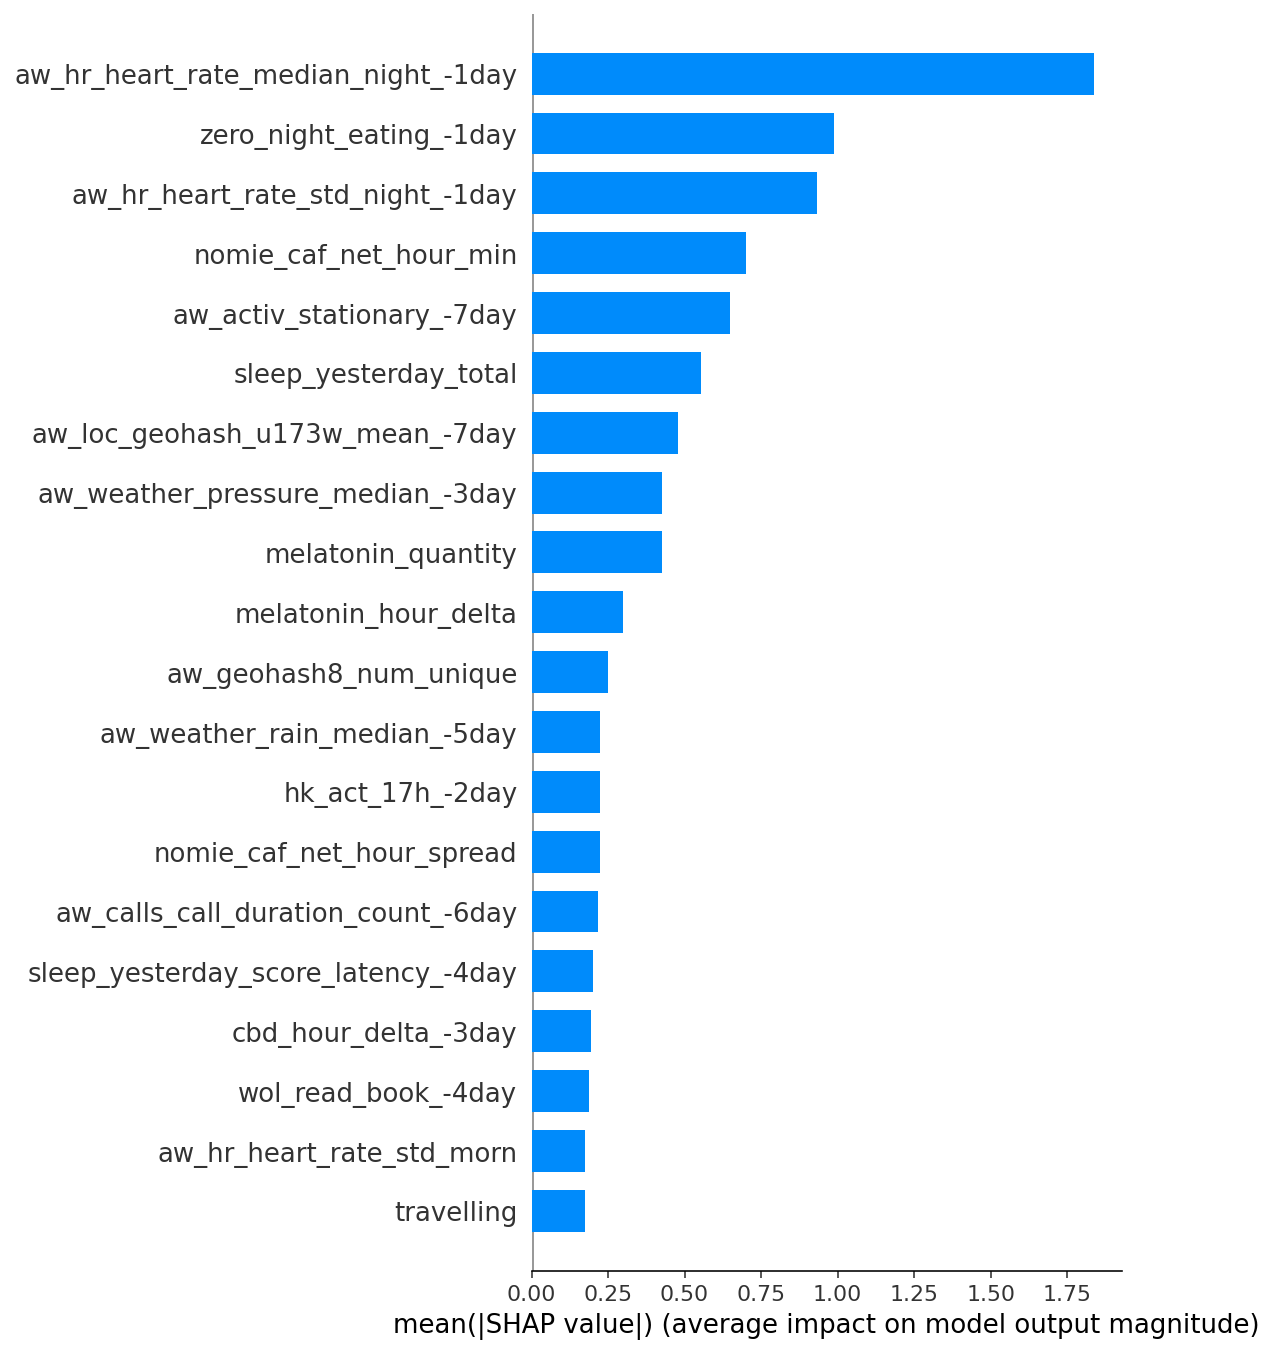

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(FIGSDIR/'interp_shap_vals.eps')
plt.show()

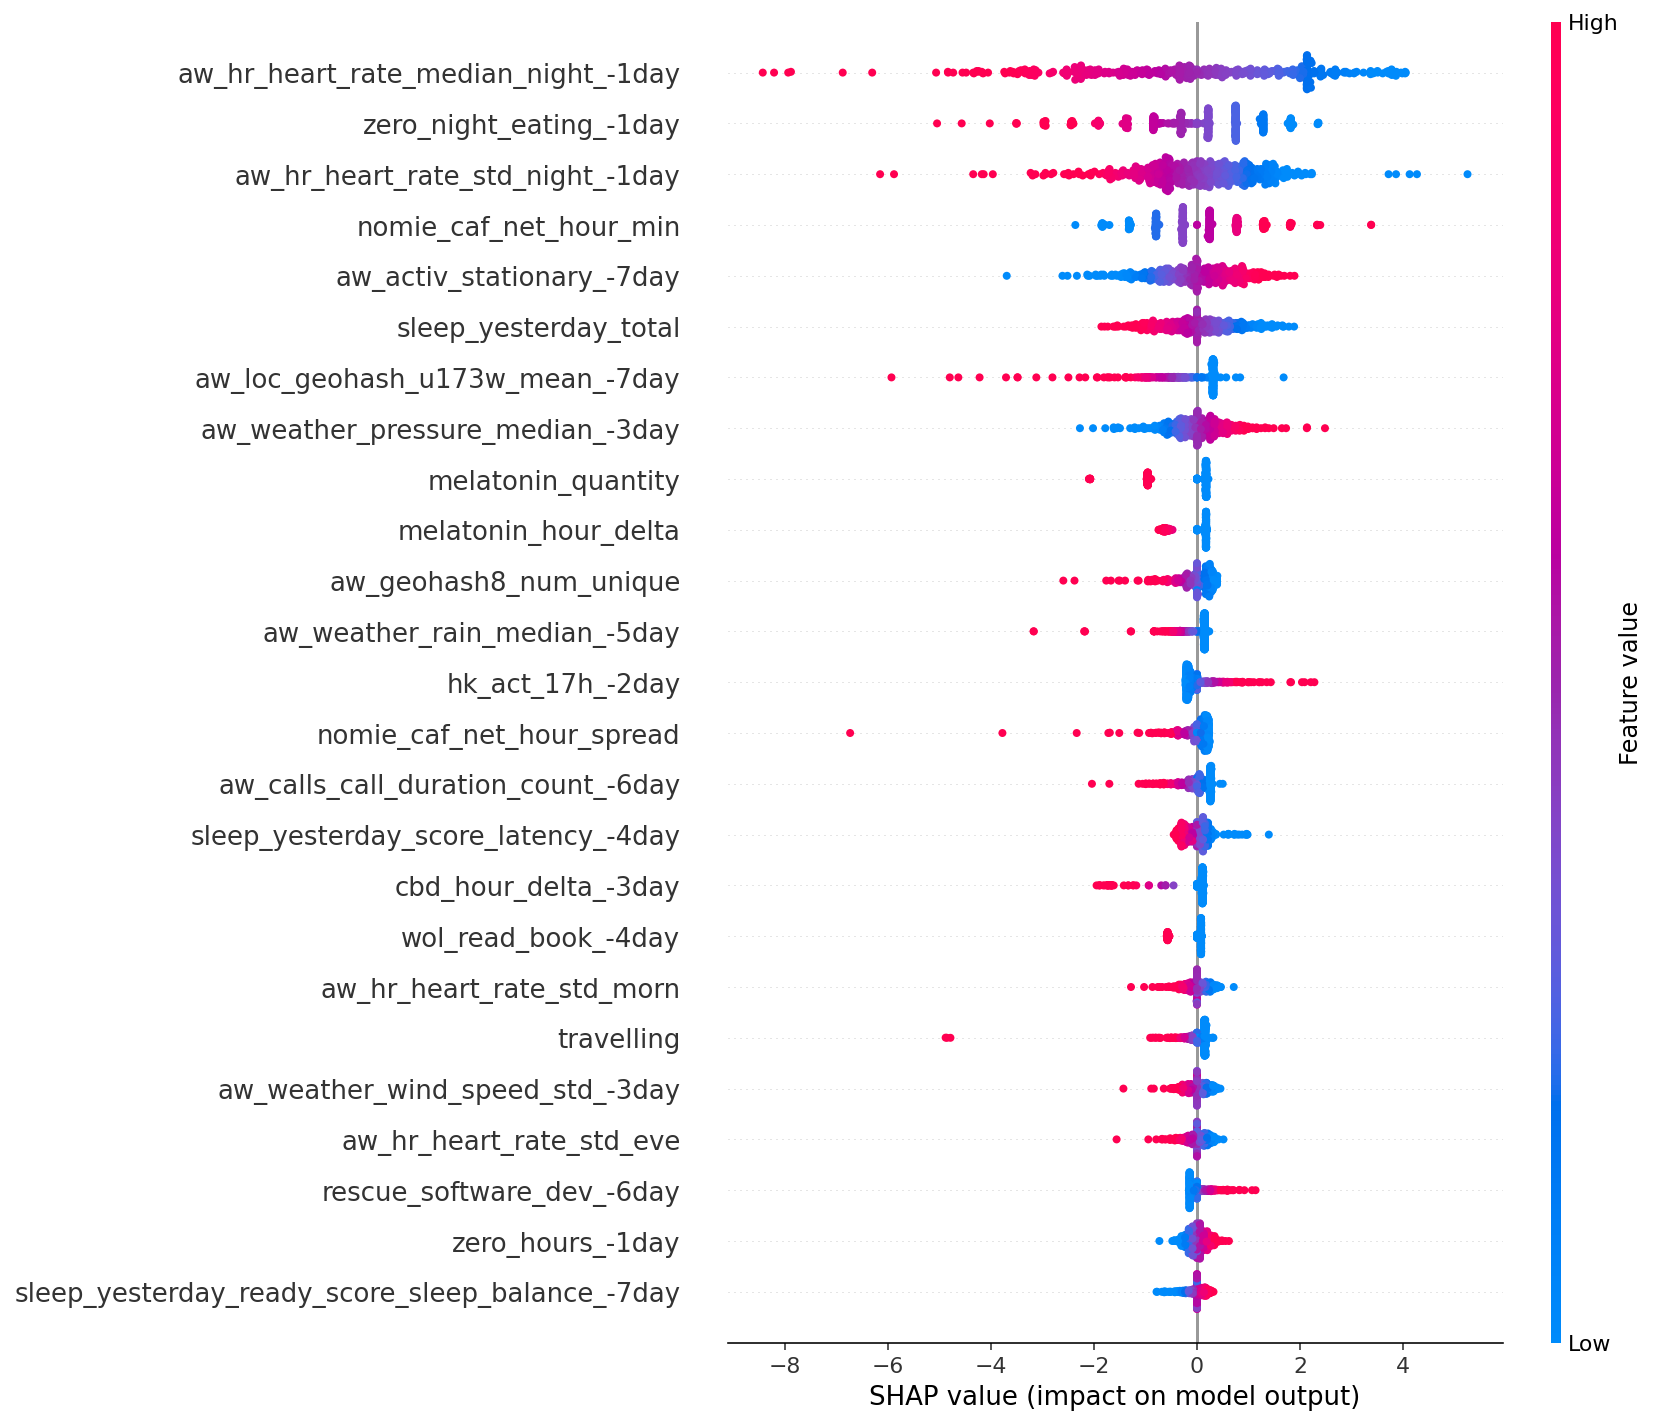

In [26]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, max_display=25, show=False, plot_size=(12,10))
plt.tight_layout()
plt.savefig(FIGSDIR/'interp_shap_summary.eps')
plt.show()

(21, 1529)


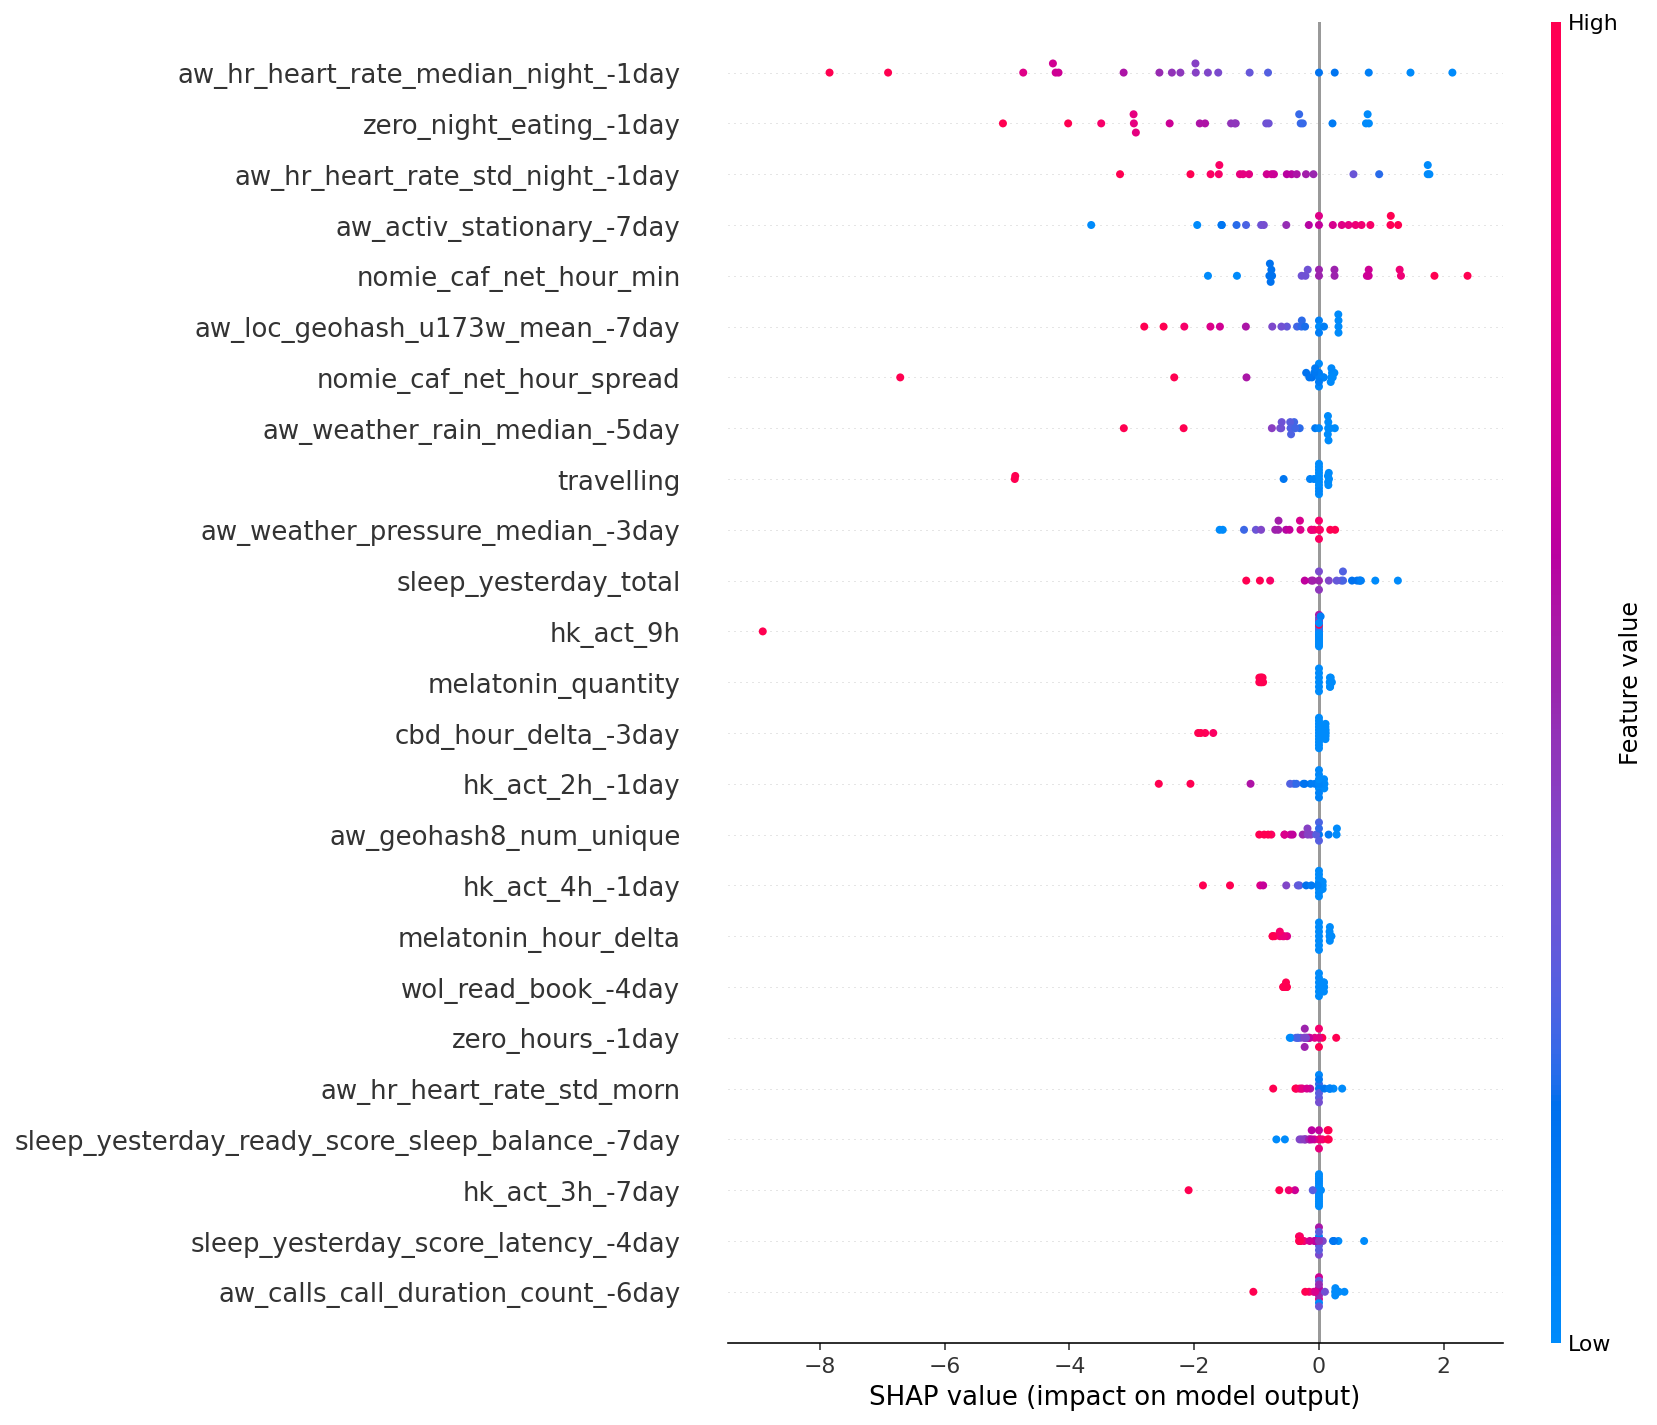

In [27]:
# Consider extremely low values
sample = X.loc[y.values < 50, :]
print(sample.shape)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, max_display=25, show=False, plot_size=(12,10))
plt.tight_layout()
plt.savefig(FIGSDIR/'interp_shap_low_values.eps')
plt.show()

(11, 1529)


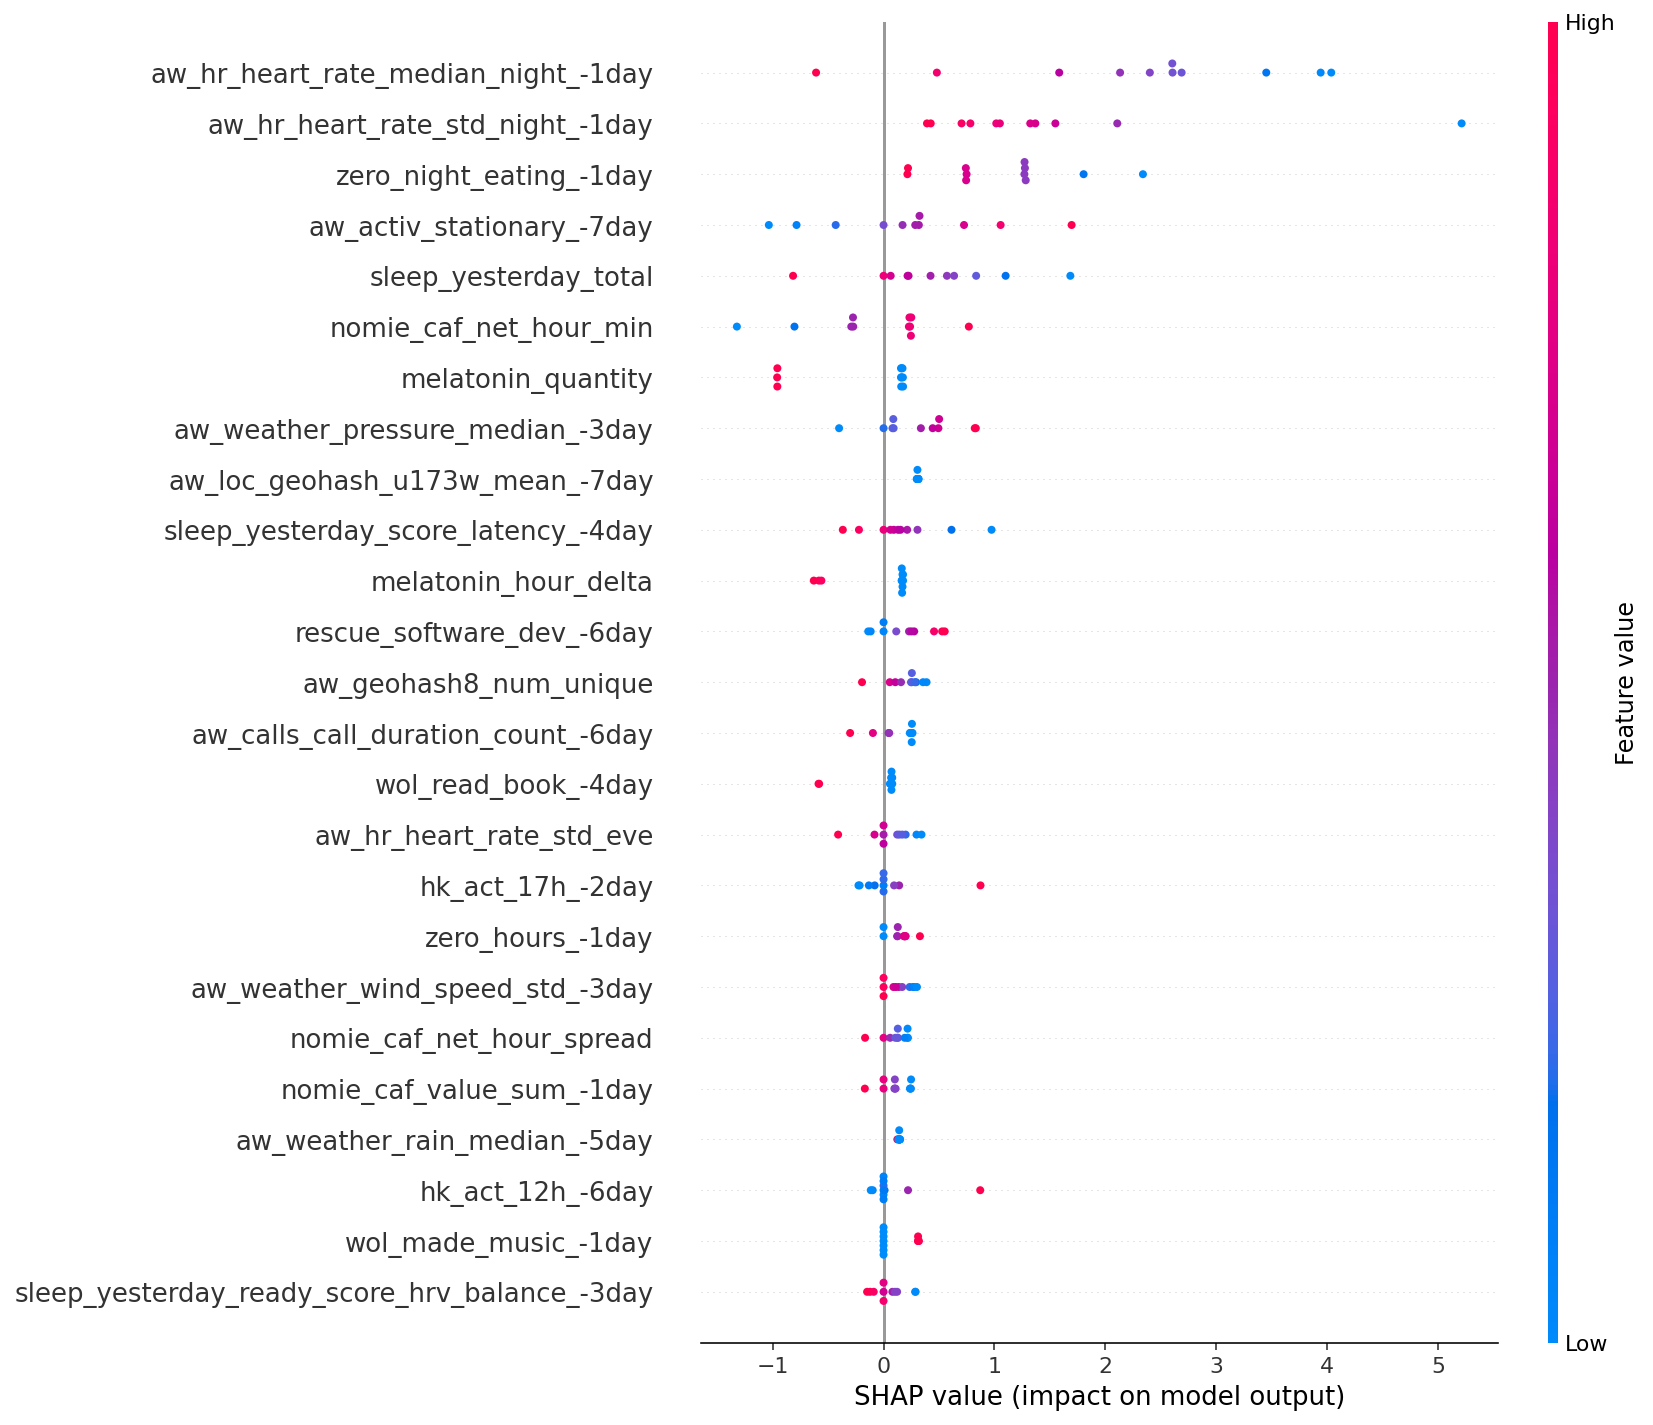

In [28]:
# Consider extremely high values
sample = X.loc[y.values > 85, :]
print(sample.shape)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, max_display=25, show=False, plot_size=(12,10))
plt.tight_layout()
plt.savefig(FIGSDIR/'interp_shap_high_values.eps')
plt.show()